In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from IPython.display import display
from funcs import get_parc_sizes

In [7]:
def remove_duplicate_labels():

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=4)

def get_results(results_dr):

    results = {}
    incomplete_cnt = 0
    result_files = os.listdir(results_dr)

    for file in result_files:
        
        result = np.load(os.path.join(results_dr, file))
        name = file.replace('.npy', '')
        
        if len(file.split('---')) == 3:

            if len(result) > 1:
                results[name] = result
            else:
                incomplete_cnt += 1
                
        else:
            
            # Get correct name
            name = '---'.join(name.split('---')[:-1])
            
            if len(result) > 1:
                
                try:
                    results[name].append(result)
                except KeyError:
                    results[name] = [result]
                    
                # Once all 5 loaded, format correctly
                if len(results[name]) == 5:
                    
                    to_fill = results[name][0].copy()
                    to_fill[:,0] = np.mean(results[name], axis=0)[:,0]
                    to_fill[:,1] = np.std(results[name], axis=0)[:,0]
                    results[name] = to_fill

            else:
                incomplete_cnt += .2
            
    print('Found:', len(results), 'Incomplete:', incomplete_cnt)
            
    return results

def conv_to_df(results, only=None):
    
    parcels, models = [], []
    targets, scores = [], []
    stds, is_binary = [], []

    for result in results:

        split = result.split('---')
        
        # Restrict to only
        if only is not None:
            if split[0] not in only:
                continue
                
        # If chunked score, skip
        if isinstance(results[result], list):
            continue

        # Add to lists
        parcels.append(split[0])
        models.append(split[1])
        targets.append(split[2])
        score = results[result]
        
        # If regression
        if len(score) == 2:
            scores.append(score[0][0])
            stds.append(score[0][1])
            is_binary.append(False)

        # If binary
        else:
            scores.append(score[1][0])
            stds.append(score[1][1])
            is_binary.append(True)

    df = pd.DataFrame()
    df['parcel'] = parcels
    df['model'] = models
    df['is_binary'] = is_binary
    df['target'] = targets
    df['score'] = scores
    df['std'] = stds
    
    df = df.set_index(['model', 'parcel']).sort_index()
    
    return df

def plot_score_by_n(scores, title, ylabel, xlim=1050):
    
    plt.figure(figsize=(12, 8))
    
    cmap = plt.get_cmap('viridis')
    
    for parcel in scores.index:
        
        s = 100
                    
        if parcel.startswith('stacked_random_'):
            color = 'mediumblue'
            alpha = 1
            label = 'Stacked'
            marker = "+"
            s = 125

        elif 'icosahedron' in parcel:
            color = cmap(0)
            alpha = 1
            label = 'Icosahedron'
            marker = 'p'

        elif 'random' in parcel:
            color = 'black'
            alpha = .5
            label = 'Random'
            marker = "+"
            
        elif 'freesurfer' in parcel:
            color = cmap(.4)
            alpha = 1
            label = 'Freesurfer Extracted'
            marker = "*"

        else:
            color = cmap(.8)
            alpha = .8
            label = 'Existing'
            marker = "o"

        n_parcels = parc_sizes[parcel]
        plt.scatter(n_parcels, scores.loc[parcel],
                    color=color, alpha=alpha,
                    label=label, marker=marker, s=s)
        
        plt.ylabel(ylabel, fontsize=16)
        plt.xlabel('Num. Parcels', fontsize=16)
        
        if xlim is not None:
            plt.xlim(-10, xlim)
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.legend()
        remove_duplicate_labels()
        
        plt.title(title, fontsize=20)
        
    os.makedirs('Figures/', exist_ok=True)
    
    plt.savefig('Figures/' + title + '_' + ylabel + '_' + str(xlim) + '.png', dpi=500)
    plt.show()
    
def plot_scores(means, ylabel):
    
    for model, name in zip(['elastic', 'svm', 'lgbm'],
                           ['Elastic-Net', 'SVM', 'LGBM']):
        
        plot_score_by_n(means.loc[model], name, ylabel, xlim=None)
        
def mean_score(df):
    return df['score'].mean()

def mean_rank(df):
    return df['rank'].mean()

def max_rank(df):
    return df['rank'].max()

def min_rank(df):
    return df['rank'].min()

def get_rank_order(df):
    
    df = df.sort_values('score', ascending=True)
    df['rank'] = np.arange(0, len(df))
    return df['rank']

def plot_ranks(df):
    
    parcel_df = df.reset_index().set_index('parcel')
    ranks = parcel_df.groupby(['model', 'target']).apply(get_rank_order)
    ranks = ranks.to_frame().reset_index()

    mean_ranks = ranks.groupby(['model', 'parcel']).apply(mean_rank)
    max_ranks = ranks.groupby(['model', 'parcel']).apply(max_rank)
    min_ranks = ranks.groupby(['model', 'parcel']).apply(min_rank)

    plot_scores(mean_ranks, ylabel='Mean Rank')
    #plot_scores(max_ranks, ylabel='Max Rank')
    #plot_scores(min_ranks, ylabel='Min Rank')
    
def plot_raw_scores(df):
    
    split_means = df.groupby(['is_binary', 'model', 'parcel']).apply(mean_score)

    regression_means = split_means.loc[False]
    binary_means = split_means.loc[True]

    plot_scores(regression_means, ylabel='Avg Explained Variance')
    plot_scores(binary_means, ylabel='Avg ROC AUC')
    
def check_best(df, top_vals=[1, 3, 5, 10]):
    
    models_in_top = {t : [] for t in top_vals}

    for target in df.target.unique():

        top_x = df[df['target'] == target].sort_values('score', ascending=False).head(top_vals[-1])

        # Compute stats
        for i in top_vals:
            models = [top_x.index[j][0] for j in range(i)]
            models_in_top[i] += models

        display(top_x)

    for i in top_vals:

        sns.countplot(models_in_top[i])
        plt.title('Models in Top ' + str(i))
        plt.show()
        
def check_best_by_model(df, models=['elastic', 'svm', 'lgbm']):
    
    # Top specific to each model for each target
    for model in models:
        print('Model:', model)

        for target in df.target.unique():
            display(df[df['target'] == target].loc[model].sort_values('score', ascending=False).head(5))

In [8]:
results = get_results('../Exp/results')

Found: 25952 Incomplete: 139.20000000000053


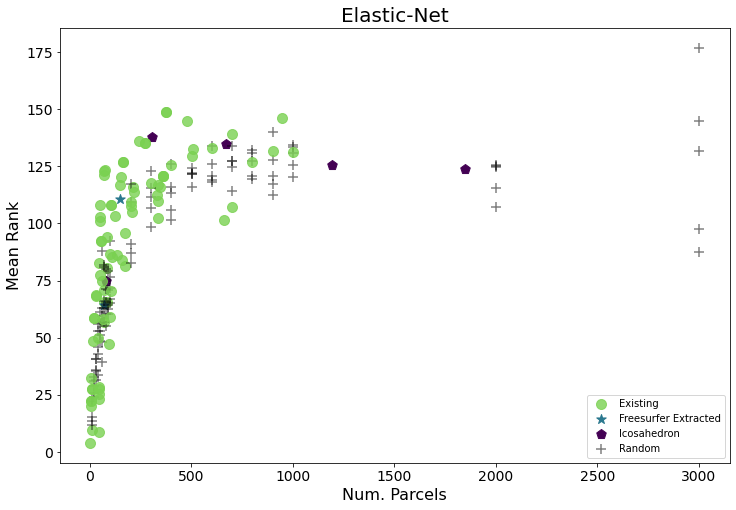

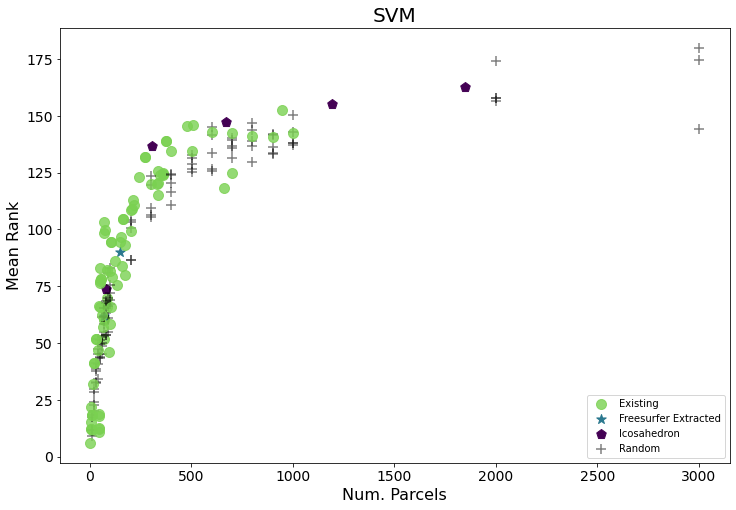

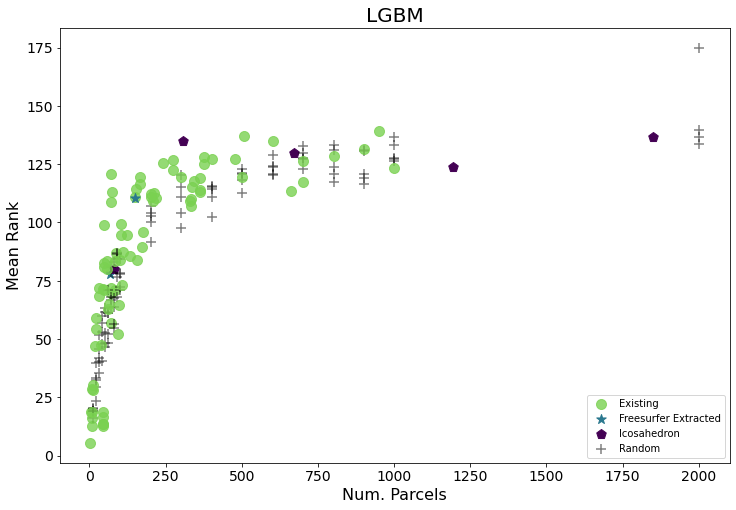

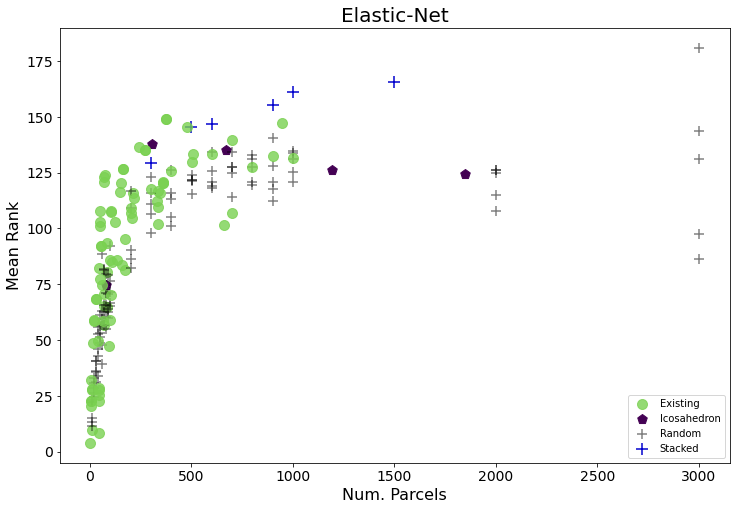

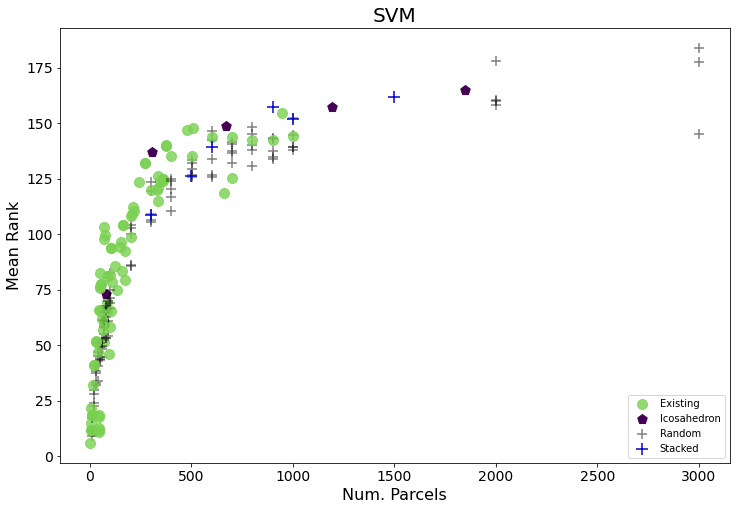

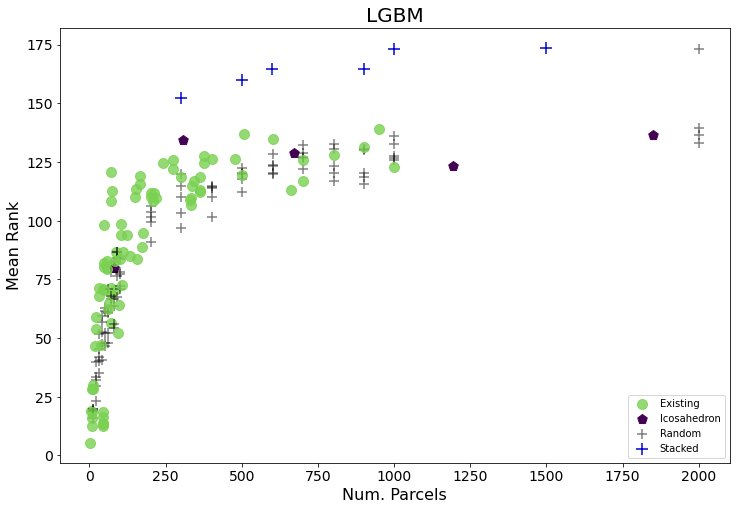

In [9]:
parc_sizes = get_parc_sizes('../parcels', fs=True)
df = conv_to_df(results, only=parc_sizes)
plot_ranks(df)

parc_sizes = get_parc_sizes('../parcels', stacked=True)
df = conv_to_df(results, only=parc_sizes)
plot_ranks(df)

In [10]:
#parc_sizes = get_parc_sizes('../parcels', fs=True)
#df = conv_to_df(results, only=parc_sizes)

#plot_ranks(df)
#plot_raw_scores(df)

#check_best(df)
#check_best_by_model(df)